# Resonant Post-fit Plots

In [1]:
from __future__ import annotations

import os
from collections import OrderedDict
import pickle

import hist
import matplotlib.pyplot as plt
import numpy as np
import plotting
import uproot
from HHbbVV.hh_vars import data_key, bg_keys, years
from hist import Hist
from HHbbVV.postprocessing.postprocessing import res_shape_vars
from pathlib import Path

from datacardHelpers import sum_templates

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
MAIN_DIR = "../../../"

plot_dir = Path(f"{MAIN_DIR}/plots/PostFit/25Apr22ResTF")
plot_dir.mkdir(exist_ok=True, parents=True)

In [4]:
cards_dir = "25Mar11nTFQCD11nTF21"
file = uproot.open(
    # f"/uscms/home/rkansal/hhcombine/cards/{cards_dir}/FitShapesB.root"
    f"/home/users/rkansal/combineenv/CMSSW_11_3_4/src/cards/{cards_dir}/FitShapesS.root"
    # f"/uscms/home/rkansal/eos/bbVV/cards/{cards_dir}/FitShapes.root"
)

In [5]:
templates_dir = Path("templates/25Feb6ResBackgrounds")

templates_dict = {}
for year in years:
    with (templates_dir / f"{year}_templates.pkl").open("rb") as f:
        templates_dict[year] = pickle.load(f)
pre_templates = sum_templates(templates_dict, years)

In [6]:
# mx, my = 3000, 250
mx, my = 900, 80

bg_keys = [k for k in bg_keys if k != "HWW"]
sig_key = f"X[{mx}]->HY[{my}]"

# (name in templates, name in cards)
hist_label_map_inverse = OrderedDict(
    [
        ("QCD", "CMS_XHYbbWW_boosted_qcd_datadriven"),
        # ("Diboson", "diboson"),
        ("TT", "ttbar"),
        ("ST", "singletop"),
        ("Z+Jets", "zjets"),
        ("W+Jets", "wjets"),
        # ("X[3000]->H(bb)Y[190](VV)", "xhy_mx3000_my190"),
        (f"X[{mx}]->HY[{my}]", f"xhy_mx{mx}_my{my}"),
        (data_key, "data_obs"),
    ]
)

hist_label_map = {val: key for key, val in hist_label_map_inverse.items()}
samples = bg_keys + [sig_key, data_key]

In [7]:
shapes = {
    "prefit": "Pre-Fit",
    # "shapes_fit_s": "S+B Post-Fit",
    "postfit": "B-only Post-Fit",
}

shape_vars = res_shape_vars

selection_regions = OrderedDict(
    [
        ("fail", "SR Fail"),
        ("pass", "SR Pass"),
        ("failBlinded", "VR Fail"),
        ("passBlinded", "VR Pass"),
    ]
)

In [8]:
hists = {}
bgerrs = {}
bgtots = {}

bins = list(shape_vars[0].axis)
binsize = np.array([b[1] - b[0] for b in bins])

for shape in shapes:
    hists[shape] = {
        region: Hist(
            hist.axis.StrCategory(samples, name="Sample"),
            *[shape_var.axis for shape_var in shape_vars],
            storage="double",
        )
        for region in selection_regions
    }
    bgerrs[shape] = {}
    bgtots[shape] = {}

    for region in selection_regions:
        h = hists[shape][region]
        bgerrs[shape][region] = []
        bgtots[shape][region] = []

        for i in range(len(shape_vars[1].axis)):  # mX bins
            # templates = file[shape][f"mXbin{i}{region}"]
            templates = file[f"mXbin{i}{region}_{shape}"]
            for key, file_key in hist_label_map_inverse.items():
                if key != data_key:
                    if file_key not in templates:
                        # print(f"No {key} in mXbin{i}{region}")
                        continue

                    data_key_index = np.where(np.array(list(h.axes[0])) == key)[0][0]
                    # h.view(flow=False)[data_key_index, :, i] = (
                    #     templates[file_key].values() * binsize
                    # )
                    h.view(flow=False)[data_key_index, :, i] = templates[file_key].values()

            # if key not in fit output, take from templates
            for key in bg_keys:
                if key not in hist_label_map_inverse:
                    data_key_index = np.where(np.array(list(h.axes[0])) == key)[0][0]
                    h.view(flow=False)[data_key_index, :] = pre_templates[region][key, ...].values()

            data_key_index = np.where(np.array(list(h.axes[0])) == data_key)[0][0]
            # h.view(flow=False)[data_key_index, :, i] = (
            #     templates[hist_label_map_inverse[data_key]].values()[1] * binsize
            # )
            h.view(flow=False)[data_key_index, :, i] = np.nan_to_num(
                templates[hist_label_map_inverse[data_key]].values()
            )

            bgerrs[shape][region].append(templates["TotalBkg"].errors())
            bgtots[shape][region].append(templates["TotalBkg"].values())

        bgerrs[shape][region] = np.array(bgerrs[shape][region])
        bgtots[shape][region] = np.array(bgtots[shape][region])
        bgerrs[shape][region] = np.minimum(bgerrs[shape][region], bgtots[shape][region])

## 1D Projected plots

In [ ]:
pass_ylims = [50, 10]
fail_ylims = [14000, 1700]
scale = 1

for shape, shape_label in shapes.items():
    for i, shape_var in enumerate(shape_vars):
        # add "invisible" subplots between main plots to add spacing
        # https://stackoverflow.com/a/53643819/3759946
        fig, axs = plt.subplots(
            5,
            3,
            figsize=(25, 30),
            gridspec_kw=dict(
                height_ratios=[3, 1, 0.6, 3, 1], width_ratios=[1, 0.12, 1], hspace=0, wspace=0
            ),
        )

        for ax in axs[2]:
            ax.set_visible(False)

        for ax in axs[:, 1]:
            ax.set_visible(False)

        for j, (region, region_label) in enumerate(selection_regions.items()):
            row = (j // 2) * 3
            col = (j % 2) * 2
            pass_region = region.startswith("pass")

            # bgerr = np.linalg.norm(bgerrs[shape][region] / bgtots[shape][region], axis=i) * np.sum(
            #     bgtots[shape][region], axis=i
            # )

            bgerr = np.linalg.norm(bgerrs[shape][region], axis=i)

            plot_params = {
                "resonant": True,
                "hists": hists[shape][region].project(0, i + 1),
                "sig_keys": [sig_key],
                "bg_keys": bg_keys,
                "bg_err": bgerr,
                "sig_scale_dict": {sig_key: 10},
                # "show": False,
                "year": "all",
                "ylim": pass_ylims[i] * scale if pass_region else fail_ylims[i] * scale,
                # "plot_data": region != "pass",
                # "title": f"{shape_label} {region_label} Region",
                # "name": f"{plot_dir}/{shape}_{region}_{shape_var.var}.pdf",
                "divide_bin_width": True,
                "axrax": (axs[row, col], axs[row + 1, col]),
                "cmslabel": "Preliminary",
                "cmsloc": 2,
            }

            plotting.ratioHistPlot(**plot_params)
            axs[row, col].text(
                0.29,
                0.915,
                region_label,
                transform=axs[row, col].transAxes,
                fontsize=24,
                fontproperties="Tex Gyre Heros:bold",
            )

        plt.savefig(f"{plot_dir}/{shape}_{shape_var.var}.pdf", bbox_inches="tight")
        plt.show()
    #     break
    # break

## 2D Plots

In [ ]:
for shape, shape_label in shapes.items():
    _ = os.system(f"mkdir -p {plot_dir}/{shape}")
    samples = (
        ["Data", "TT", "V+Jets", "QCD", "X[3000]->H(bb)Y[190](VV)"]
        if shape == "shapes_prefit"
        else ["TT", "V+Jets", "QCD"]
    )

    plotting.hist2ds(
        hists[shape],
        f"{plot_dir}/{shape}/",
        regions=["pass", "fail", "passBlinded", "failBlinded"],
        region_labels=selection_regions,
        samples=samples,
        # fail_zlim=5e3,
        # pass_zlim=1.0,
    )

## Transfer factor

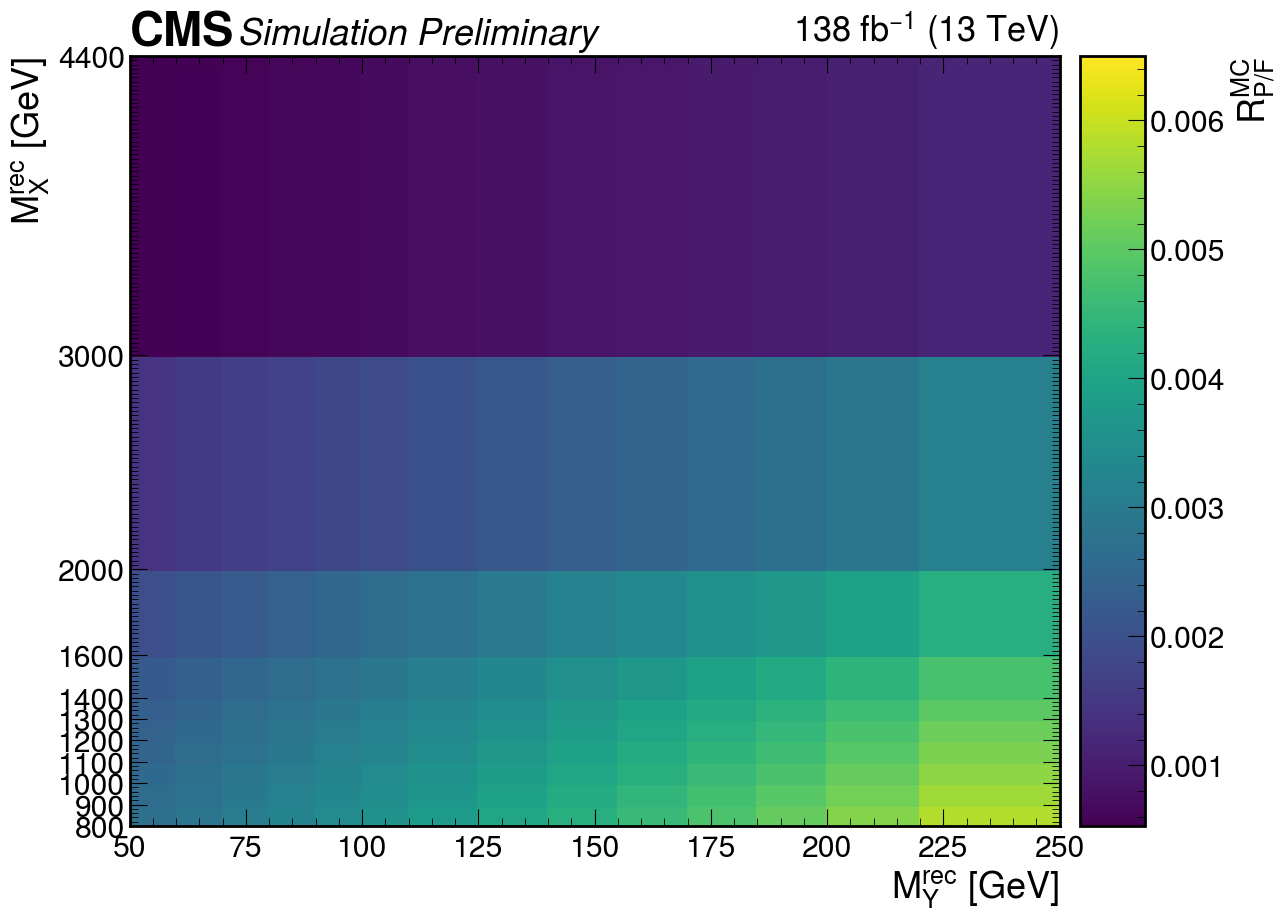

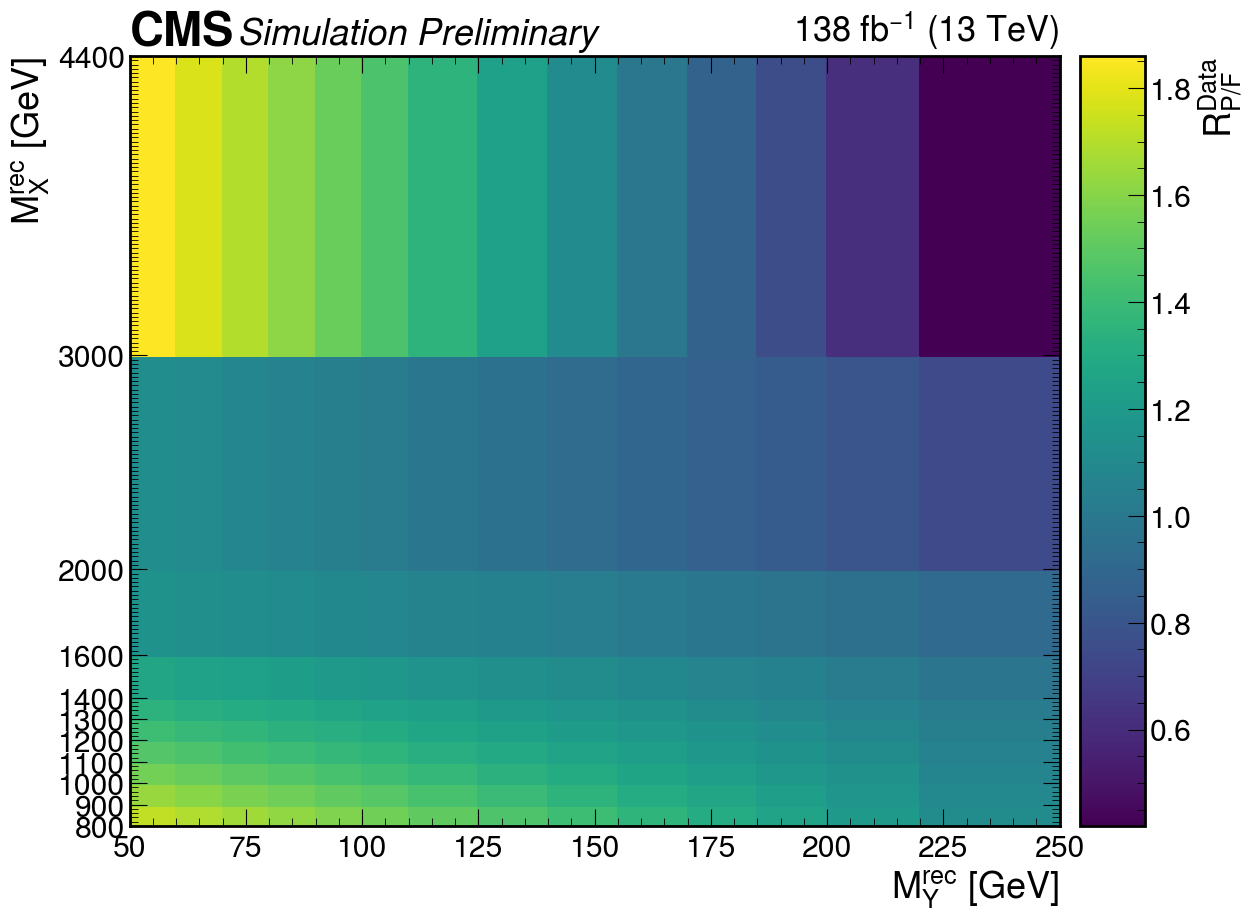

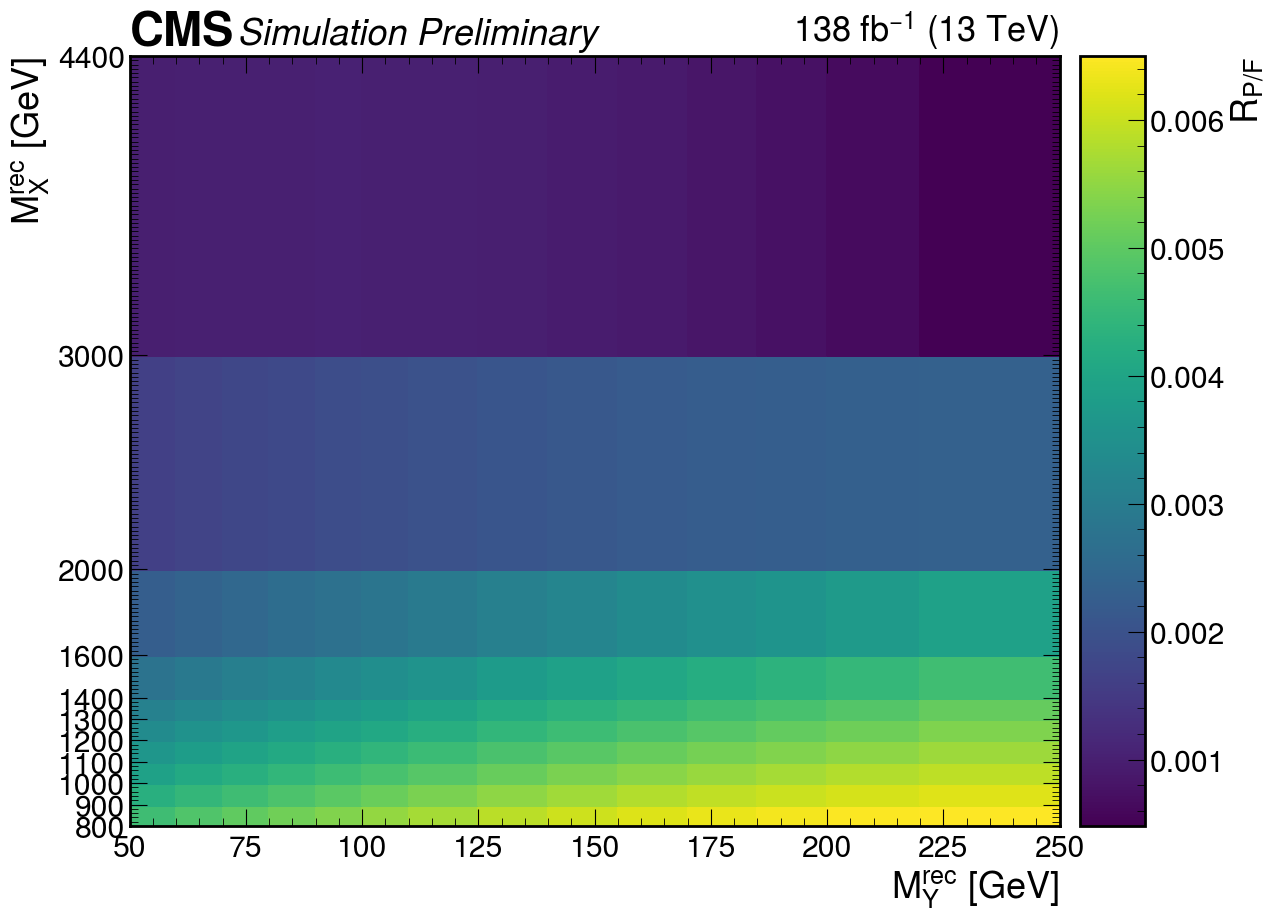

In [ ]:
tftot = hists["postfit"]["pass"]["QCD", ...] / hists["postfit"]["fail"]["QCD", ...]
with Path(f"{MAIN_DIR}/plots/QCDTF/25Apr22TF/qcdtf.pkl").open("rb") as f:
    tfqcd = pickle.load(f)

for prelim, plabel in zip([True, False], ["prelim_", ""]):
    plotting.plot_tf(
        tfqcd,
        label=r"$R^\mathrm{MC}_\mathrm{P/F}$",
        vmax=6.5e-3,
        plot_dir=plot_dir,
        name=f"{plabel}tfqcd",
        prelim=prelim,
        show=prelim,
    )
    plotting.plot_tf(
        tftot / tfqcd.values(),
        label=r"$R^\mathrm{Data}_\mathrm{P/F}$",
        plot_dir=plot_dir,
        name=f"{plabel}tfdata",
        prelim=prelim,
        show=prelim,
    )
    plotting.plot_tf(
        tftot,
        label=r"$R_\mathrm{P/F}$",
        vmax=6.5e-3,
        plot_dir=plot_dir,
        name=f"{plabel}tftot",
        prelim=prelim,
        show=prelim,
    )